<font size="5">**Connecting to the database**</font>
<br /><br />
<font size="3">First, we import the necessary libraries.</font>

In [1]:
import mysql.connector as mysql
import database as db
import csv, sys
import image_generator
import feature_extractor
import numpy as np
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#!unset CUDA_VISIBLE_DEVICES

<font size="3">Now, we establish the connection.</font>

In [2]:
myDB = db.connect_db("inference")
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]

<font size="5">**Extracting the features**</font>

<font size="3">We start the *image generator* class and choose the range of images.</font>

In [3]:
image_generator.main()
imgGen = image_generator.ImageGenerator('images/val/images', 'images/val/val.txt', 'images/val/synset_words.txt')
label_list = imgGen.get_label_list() 

images/val/images\ILSVRC2012_val_00024099.JPEG burrito
images/val/images\ILSVRC2012_val_00012393.JPEG bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis
images/val/images\ILSVRC2012_val_00023741.JPEG stretcher
images/val/images\ILSVRC2012_val_00030225.JPEG lemon
images/val/images\ILSVRC2012_val_00002969.JPEG tiger shark, Galeocerdo cuvieri
images/val/images\ILSVRC2012_val_00028873.JPEG bagel, beigel
images/val/images\ILSVRC2012_val_00031284.JPEG Polaroid camera, Polaroid Land camera
images/val/images\ILSVRC2012_val_00003010.JPEG stole
images/val/images\ILSVRC2012_val_00017600.JPEG limpkin, Aramus pictus
images/val/images\ILSVRC2012_val_00030606.JPEG pug, pug-dog


In [4]:
img_nums = []
for i in range(1, 50001):                 # the range of images can be selected here
    img_nums.append(i)

img_paths = []
filenames = []
for i in range(len(img_nums)):
    img_path, _ = imgGen.get_image_data(img_nums[i])
    img_paths.append(img_path)                                             # we obtain the image paths and filenames
for i in range(len(img_nums)):
    img_name = imgGen.get_image_filename(img_nums[i])
    filenames.append(img_name)

<font size="3">Extracting the <font color="green">seven</font> selected features from the images.</font>

50000


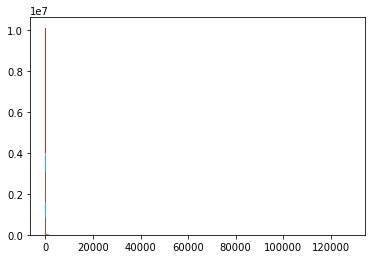

In [5]:
features_list = []                            # this list hold features of all 50k images

for i in range(len(img_paths)):
    filename = img_paths[i]
    features_list.append(feature_extractor.extract_features(filename))
print(len(features_list))

In [6]:
import math
nan_counter = 0
for i in range(len(features_list)):
    for j in range(len(features_list[i])):
        if math.isnan(j):
            nan_counter += 1
            features_list[i][j] = 0

In [10]:
nan_counter

0

<font size="3">Normalizing and standardizing the data.</font>

In [10]:
#import sklearn.preprocessing as preprocessing
#features_list1 = np.asarray(features_list)
#min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))        # scaling of features 0-1
#features_list1 = min_max_scaler.fit_transform(features_list1)

In [11]:
import sklearn.preprocessing as preprocessing

features_list = preprocessing.normalize(features_list)
features_list = preprocessing.scale(features_list)

In [9]:
myDB = db.connect_db("inference")
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]

<font size="5">**Determining the best <font color="green">top-1</font> and <font color="green">top-5</font> model for each image**</font>

<font size="3">Connecting to the <font color="green">database</font> to determine the best top-1 and top-5 models for each image.</font>

In [11]:
best_top_1_model_names = []
best_top_5_model_names = []
list_model = ["mobilenet_v1", "inception_v4", "resnet_v1_152"]
for i in range(len(img_nums)):
    best_top_1_model_names.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 1))  # best top-1 model for the image
    best_top_5_model_names.append(db.determine_best_top_n_model("inference", img_nums[i], list_model, 5))  # best top-5 model for the image

In [12]:
def best_models(best_top_model_names):
    best_models = []
    for i in range(len(best_top_model_names)):
        if best_top_model_names[i] == 'mobilenet_v1':
            best_models.append([1, 0, 0])
        elif best_top_model_names[i] == 'inception_v4':
            best_models.append([0, 1, 0])
        elif best_top_model_names[i] == 'resnet_v1_152':
            best_models.append([0, 0, 1])
        elif best_top_model_names[i] == 'failed':
            best_models.append([0, 0, 0])
    return best_models

In [13]:
top_1_best_models = best_models(best_top_1_model_names)

In [14]:
top_5_best_models = best_models(best_top_5_model_names)

<font size="5">**Writing the data to a csv file**</font>
<br /><br />
<font size="3">Creating the best <font color="green">top-1</font> model csv.</font>

In [15]:
filename = 'all_new_features_hier_norm_top_1.csv'
with open('all_new_features_hier_norm_top_1.csv', mode='w', newline='') as featuresFile1:
    features_writer = csv.writer(featuresFile1, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_1_best_models[i][0], top_1_best_models[i][1], top_1_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)

<font size="3">Completing the same operation for <font color="green">top-5</font>.</font>

In [16]:
filename = 'all_new_features_hier_norm_top_5.csv'
with open('all_new_features_hier_norm_top_5.csv', mode='w', newline='') as featuresFile2:
    features_writer = csv.writer(featuresFile2, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    features_writer.writerow(['filename', 'Mobilenet_v1', 'Inception_v4', 'Resnet_v1_152', 'kp_surf',
                              'average_perceived_brightness', 'contrast', 'area_by_perim', 'aspect_ratio', 'edge_length1', 
                             'hue1'])
    for i in range(len(features_list)):
        row = ([filenames[i], top_5_best_models[i][0], top_5_best_models[i][1], top_5_best_models[i][2], features_list[i][0], features_list[i][1], features_list[i][2],
               features_list[i][3], features_list[i][4], features_list[i][5], features_list[i][6]])
        features_writer.writerow(row)